In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
### Utility Functions
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
# Delete old database file
normalized_database_filename = 'normalized1.db'
conn = create_connection(normalized_database_filename, delete_db=True)

In [4]:
#Reading the dataframe from file
df=pd.read_csv('solar.csv')
df1=df.copy()
df2=df.copy()
df3=df.copy()
df4=df.copy()
df5=df.copy()
df6=df.copy()

/Users/marksigalov/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
#Creating the Project Table
#Dataframe ColumnName	Column Name in DB Table
'''
Project Number(Common)	1(ProjectID)[Primary Key]
Sector	7(Sector)
Program Type	8(Program Type)
Solicitation	9(Solicitation)
Electric Utility	10(Electric Utility)
Purchase Type	11(PurchaseType)
Project Status	14(Project Status)
Contractor	15(Contractor)
'''

def step1_create_project_table(normalized_database_filename):
    ll=[]
    for l in df.iterrows():
        ll.append((str(l[1][1]),str(l[1][7]),str(l[1][8]),str(l[1][9]),str(l[1][10]),
                   str(l[1][11]),str(l[1][14]),str(l[1][15])))
    
    conn_norm=create_connection(normalized_database_filename)
    create_table(conn_norm,"""create table Project(ProjectID TEXT NOT NULL PRIMARY KEY,Sector TEXT,
    Program Type TEXT, Solicitation TEXT, ElectricUtility TEXT, PurchaseType TEXT, ProjectStatus TEXT,
    Contractor TEXT,UNIQUE(ProjectID))""","Project")
    conn_norm.commit()
    cur = conn_norm.cursor()
    cur.executemany("INSERT INTO Project VALUES (?, ?, ?, ?, ?, ?, ?, ?)", ll)
    conn_norm.commit()

In [6]:
#Verifying the table creation & insertion of Project
normalized_database_filename = 'normalized1.db'
step1_create_project_table(normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Project""", conn)
print(df.head())

          ProjectID           Sector                              Program  \
0  2011-189637-SLPR      Residential         Residential/Small Commercial   
1  2013-530718-Sola      Residential         Residential/Small Commercial   
2  2014-646148-Sola      Residential         Residential/Small Commercial   
3           31307-1  Non-Residential  Commercial/Industrial (Competitive)   
4               431      Residential         Residential/Small Commercial   

            Solicitation              ElectricUtility PurchaseType  \
0  SLPR 2010 Residential  Long Island Power Authority     Purchase   
1          Solar Pioneer  Long Island Power Authority     Purchase   
2          Solar Pioneer  Long Island Power Authority     Purchase   
3              PON 2589B                National Grid     Purchase   
4                PON 716         NYS Electric and Gas          nan   

  ProjectStatus            Contractor  
0      Complete                   nan  
1      Complete  SUNWIZE TECHNOLOGIE

In [7]:
#Creating the ProjectLocation Table
#Dataframe ColumnName	Column Name in DB Table
'''
ProjectLocationID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
City	3(City)
County	4(County)
Zip Code	6(Zip Code)
'''

def step2_create_project_location_table(normalized_database_filename):
    ll1=[]
    df=pd.read_csv('solar.csv')
    for l in df1.iterrows():
        ll1.append((l[0]+1,l[1][6],str(l[1][1]),l[1][3],l[1][4])) 

    conn_norm=create_connection(normalized_database_filename)
    create_table(conn_norm,"""create table ProjectLocation(ProjectLocationID INTEGER NOT NULL PRIMARY KEY, 
    ZipCode TEXT NOT NULL, ProjectID TEXT NOT NULL,City TEXT,County TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectLocationID))""","ProjectLocation")
    conn_norm.commit()
    cur = conn_norm.cursor()
    cur.executemany("INSERT INTO ProjectLocation VALUES (?, ?, ?, ?, ?)", ll1)
    conn_norm.commit()

In [8]:
#Verifying the table creation & insertion of ProjectLocation
normalized_database_filename = 'normalized1.db'
step2_create_project_location_table(normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectLocation""", conn)
print(df.head())

/Users/marksigalov/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


   ProjectLocationID ZipCode         ProjectID              City    County
0                  1   11763  2011-189637-SLPR           Medford   Suffolk
1                  2   11933  2013-530718-Sola         Calverton   Suffolk
2                  3   11788  2014-646148-Sola         Hauppauge   Suffolk
3                  4   12866           31307-1  Saratoga Springs  Saratoga
4                  5   14886               431       Trumansburg  Tompkins


In [9]:
#Creating the InverterDetails Table
#Dataframe ColumnName	Column Name in DB Table
'''
InverterDetailsID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Primary Inverter Manufacturer	16(PriInvetMft)
Primary Inverter Model Number	17(PriInvetModNo)
Total Inverter Quantity	18(TotalInvtQt)
'''

def step3_create_inverter_details_table(data_filename, normalized_database_filename):
    ll=[]
    df=pd.read_csv('solar.csv')
    for l in df2.iterrows():
        ll.append((l[0]+1,l[1][1],l[1][16],l[1][17],l[1][18])) 
    
    conn_norm=create_connection(normalized_database_filename)
    create_table(conn_norm,"""create table InverterDetails(InverterDetailsID INTEGER NOT NULL PRIMARY KEY, 
    ProjectID TEXT NOT NULL, PriInvetMft TEXT, PriInvetModNo TEXT,TotalInvtQt TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(InverterDetailsID))""","InverterDetails")
    conn_norm.commit()
    cur = conn_norm.cursor()
    cur.executemany("INSERT INTO InverterDetails VALUES (?, ?, ?, ?, ?)", ll)
    conn_norm.commit()

In [10]:
#Verifying the table creation & insertion of InverterDetails
normalized_database_filename = 'normalized1.db'
data_filename = 'solar.csv'
step3_create_inverter_details_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM InverterDetails""", conn)
print(df.head())

/Users/marksigalov/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


   InverterDetailsID         ProjectID  PriInvetMft PriInvetModNo TotalInvtQt
0                  1  2011-189637-SLPR         None          None         0.0
1                  2  2013-530718-Sola    Power-One          None         2.0
2                  3  2014-646148-Sola    SolarEdge          None         1.0
3                  4           31307-1         None          None        None
4                  5               431  Fronius USA       IG 2000         1.0


In [11]:
#Creating the PVModuleDetails Table
#Dataframe ColumnName	Column Name in DB Table
'''
PVModuleDetailsID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Primary PV Module Manufacturer	19(PriPVMft)
PV Module Model Number	20(PriPVModNo)
Total PV Module Quantity	21(TotalPVQt)
'''

def step4_create_pvmodule_details_table(data_filename, normalized_database_filename):
    ll=[]
    for l in df3.iterrows():
        ll.append((l[0]+1,l[1][1],l[1][19],l[1][20],l[1][21]))
    
    conn_norm=create_connection(normalized_database_filename)
    create_table(conn_norm,"""create table PVModuleDetails(PVModuleDetailsID INTEGER NOT NULL PRIMARY KEY, 
    ProjectID TEXT NOT NULL, PriPVMft TEXT, PriPVModNo TEXT,TotalPVQt TEXT, 
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(PVModuleDetailsID))""","PVModuleDetails")
    conn_norm.commit()
    cur = conn_norm.cursor()
    cur.executemany("INSERT INTO PVModuleDetails VALUES (?, ?, ?, ?, ?)", ll)
    conn_norm.commit()

In [12]:
#Verifying the table creation & insertion of PVModuleDetails
normalized_database_filename = 'normalized1.db'
data_filename = 'solar.csv'
step4_create_pvmodule_details_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM PVModuleDetails""", conn)
print(df.head())

   PVModuleDetailsID         ProjectID    PriPVMft  PriPVModNo TotalPVQt
0                  1  2011-189637-SLPR        None        None       0.0
1                  2  2013-530718-Sola  AU OPTRONI        None      40.0
2                  3  2014-646148-Sola  SOLAR WORL        None      46.0
3                  4           31307-1        None        None      None
4                  5               431  SolarWorld  SW175 mono      12.0


In [13]:
#Creating the ProjectTimeline Table
#Dataframe ColumnName	Column Name in DB Table
'''
ProjectTimelineID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Date Application Received	11(DtAppReceived)
Date Completed	12(DtCompleted)
'''

def step5_create_project_timeline_table(data_filename, normalized_database_filename):
    ll=[]
    for l in df4.iterrows():
        ll.append((l[0]+1,l[1][1],l[1][12],l[1][13]))
    
    
    conn_norm=create_connection(normalized_database_filename)
    create_table(conn_norm,"""create table ProjectTimeline(ProjectTimelineID INTEGER NOT NULL PRIMARY KEY, ProjectID 
    TEXT NOT NULL, DtAppReceived TEXT, DtCompleted TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectTimelineID))""","ProjectTimeline")
    conn_norm.commit()
    cur = conn_norm.cursor()
    cur.executemany("INSERT INTO ProjectTimeline VALUES (?, ?, ?, ?)", ll)
    conn_norm.commit()

In [14]:
#Verifying the table creation & insertion of ProjectTimeline
normalized_database_filename = 'normalized1.db'
data_filename = 'solar.csv'
step5_create_project_timeline_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectTimeline""", conn)
print(df.head())

   ProjectTimelineID         ProjectID DtAppReceived DtCompleted
0                  1  2011-189637-SLPR    10/02/2008  10/02/2008
1                  2  2013-530718-Sola    03/01/2013  06/27/2013
2                  3  2014-646148-Sola    04/03/2014  10/23/2015
3                  4           31307-1    02/22/2013  09/23/2013
4                  5               431    10/30/2007  04/24/2008


In [15]:
#Creating the ProjectCost Table
#Dataframe ColumnName	Column Name in DB Table
'''
ProjectCostID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Project Cost	22(ProjectCost)
$Incentive	23(Incentive)
Remote Net Metering	26(RemNetMet)
Affordable Solar	27(AffSolar)
Green Jobs Green New York Participant	29(GreenCertified)
'''

def step6_create_project_cost_table(data_filename, normalized_database_filename):
    ll=[]
    for l in df5.iterrows():
        ll.append((l[0]+1,l[1][1],l[1][22],l[1][23],l[1][26],l[1][27],l[1][29]))
    
    conn_norm=create_connection(normalized_database_filename)
    create_table(conn_norm,"""create table ProjectCost(ProjectCostID INTEGER NOT NULL PRIMARY KEY, ProjectID 
    TEXT NOT NULL, ProjectCost TEXT, Incentive TEXT, RemNetMet TEXT, AffSolar TEXT, GreenCertified TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectCostID))""","ProjectCost")
    conn_norm.commit()
    cur = conn_norm.cursor()
    cur.executemany("INSERT INTO ProjectCost VALUES (?, ?, ?, ?, ?, ?, ?)", ll)
    conn_norm.commit()

In [16]:
#Verifying the table creation & insertion of ProjectCost
normalized_database_filename = 'normalized1.db'
data_filename = 'solar.csv'
step6_create_project_cost_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectCost""", conn)
print(df.head())

   ProjectCostID         ProjectID ProjectCost Incentive RemNetMet AffSolar  \
0              1  2011-189637-SLPR     11000.0    7560.0      None       No   
1              2  2013-530718-Sola     49088.0   15000.0      None       No   
2              3  2014-646148-Sola     37950.0   5504.63      None       No   
3              4           31307-1   1825000.0  570719.0      None       No   
4              5               431     21100.0    8400.0      None       No   

  GreenCertified  
0             No  
1             No  
2             No  
3             No  
4             No  


In [17]:
#Creating the ProjectProd Table
#Dataframe ColumnName	Column Name in DB Table
'''
ProjectProdID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Total Nameplate kW DC	24(TotNamePlateKWDC)
Expected KWh Annual Production	25(ExpectKWhAnnProd)
Community Distributed Generation	28(CommDistGener)
'''

def step7_create_project_prod_table(data_filename, normalized_database_filename):
    ll=[]
    for l in df6.iterrows():
        #if l[1][24]==0 or l[1][24]==np.nan: 
        #    ll.append((l[0]+1,l[1][1],l[1][24],l[1][25],l[1][28],0))
        #else:
            #pc=float(l[1][22])
            #tnkwhdc=float(l[1][24])
            #eff=1-(pc/tnkwhdc)
            #ll.append((l[0]+1,l[1][1],l[1][24],l[1][25],l[1][28],eff*100))
        ll.append((l[0]+1,l[1][1],l[1][24],l[1][25],l[1][28]))
    
    conn_norm=create_connection(normalized_database_filename)
    create_table(conn_norm,"""create table ProjectProd(ProjectProdID INTEGER NOT NULL PRIMARY KEY, ProjectID 
    TEXT NOT NULL, TotNamePlateKWDC TEXT, ExpectKWhAnnProd TEXT, CommDistGener TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectProdID))""","ProjectProd")
    conn_norm.commit()
    cur = conn_norm.cursor()
    cur.executemany("INSERT INTO ProjectProd VALUES (?, ?, ?, ?, ?)", ll)
    conn_norm.commit()

In [18]:
#Verifying the table creation & insertion of ProjectProd
normalized_database_filename = 'normalized1.db'
data_filename = 'solar.csv'
step7_create_project_prod_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectProd""", conn)
print(df.head())

   ProjectProdID         ProjectID TotNamePlateKWDC ExpectKWhAnnProd  \
0              1  2011-189637-SLPR             2.16           2535.0   
1              2  2013-530718-Sola             10.4          12208.0   
2              3  2014-646148-Sola            12.65          14849.0   
3              4           31307-1           598.26         576483.0   
4              5               431              2.1           2428.0   

  CommDistGener  
0            No  
1            No  
2            No  
3            No  
4            No  


In [19]:
#Converting County Code to FIPS Code for Populating the Choropleth Map
def county_to_3_digit_fips_code(df_counties_fips):  
    ll_counties_fips=[]
    for ele in df_counties_fips.iterrows():
        num=str(ele[1][0])
        ll_counties_fips.append((num,ele[1][1]))
    return ll_counties_fips

def df_county_to_fips_code(df, ll_counties_fips):
    df[pd.isnull(df['County'])]
    ll_df_fips=[]
    for ele in df['County']:
        flag=0
        for i in range(len(ll_counties_fips)):
            #ele=str(ele)
            if type(ele)==float:
                ele=str(ele)
                ele=ele.strip()
            ele=ele.replace('.','')
            if ele==ll_counties_fips[i][1]:
                #print(type(ll[i][1]))
                ll_df_fips.append(ll_counties_fips[i][0])
                flag=1
        if flag==0:
            ll_df_fips.append('125')
    return ll_df_fips

def year_filtered_dataframe(col,table,year):
    sql_statement="""select County, pt.DtAppReceived, {0} from 
            ProjectTimeline AS pt 
            INNER JOIN 
            {1} AS pd
            on pt.ProjectID=pd.ProjectID
            INNER JOIN 
            ProjectLocation AS pl
            on pt.ProjectID=pl.ProjectID
            where cast(substr(pt.DtAppReceived,length(pt.DtAppReceived)-3,4) as INTEGER)<={2}"""
    sql_statement = sql_statement.format(col,table,year)
    normalized_database_filename = 'normalized1.db'
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df_yr = pd.read_sql_query(sql_statement, conn)
    df_yr = df_yr.dropna()
    df_yr = df_yr.replace('','0')
    df_yr[col]= df_yr[col].astype(float) 
    return df_yr

In [20]:
import pandas as pd
import numpy as np

def df_year_filtered(col,table,year):
    #Filtering the year wise data
    df_year = year_filtered_dataframe(col,table,year)
    return df_year

def ll_counties_fips():
    #Reading the dataframes for the solar and counties
    #df['Expected KWh Annual Production']=df['Expected KWh Annual Production'].replace(np.nan,0)
    df_counties_fips = pd.read_csv('Counties.csv',error_bad_lines=False)

    #Converting the county to 3 digit fips code
    ll_counties_fips = county_to_3_digit_fips_code(df_counties_fips)
    return ll_counties_fips

def ll_df_fips(df, ll_counties_fips):
    #Adding the fips code of all the counties in the dataframe
    ll_df_fips = df_county_to_fips_code(df,ll_counties_fips)
    return ll_df_fips

In [21]:
import geopandas as gpd
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import plotly.express as px
yr=int(input("Enter year:"))
col=str(input("Enter column:"))
table=str(input("Enter table:"))
for year in range(yr,yr+1): 
    df_fips_expectedAnnProdKwh=pd.DataFrame()
    df_year=df_year_filtered(col,table,year)
    ll=ll_counties_fips()
    ll2=ll_df_fips(df_year, ll)

    df_fips_expectedAnnProdKwh['solarprod']=df_year[col]

    df_fips_expectedAnnProdKwh['fips']=ll2
    df_fips_expectedAnnProdKwh['sum_kwh_prod']=df_fips_expectedAnnProdKwh.groupby('fips').transform('sum')
    df_fips_expectedAnnProdKwh=df_fips_expectedAnnProdKwh.sort_values(by=['fips'])
    df_fips_expectedAnnProdKwh=df_fips_expectedAnnProdKwh.drop(['solarprod'],axis=1)
    
    #Using Choropleth
    fig = px.choropleth(df_fips_expectedAnnProdKwh, geojson=counties, locations='fips', color='sum_kwh_prod',
                           color_continuous_scale="Viridis",
                           range_color=(0, max(df_fips_expectedAnnProdKwh['sum_kwh_prod'])),
                           scope="usa",
                           labels={'sum_kwh_prod':col}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

Enter year:


ValueError: invalid literal for int() with base 10: ''

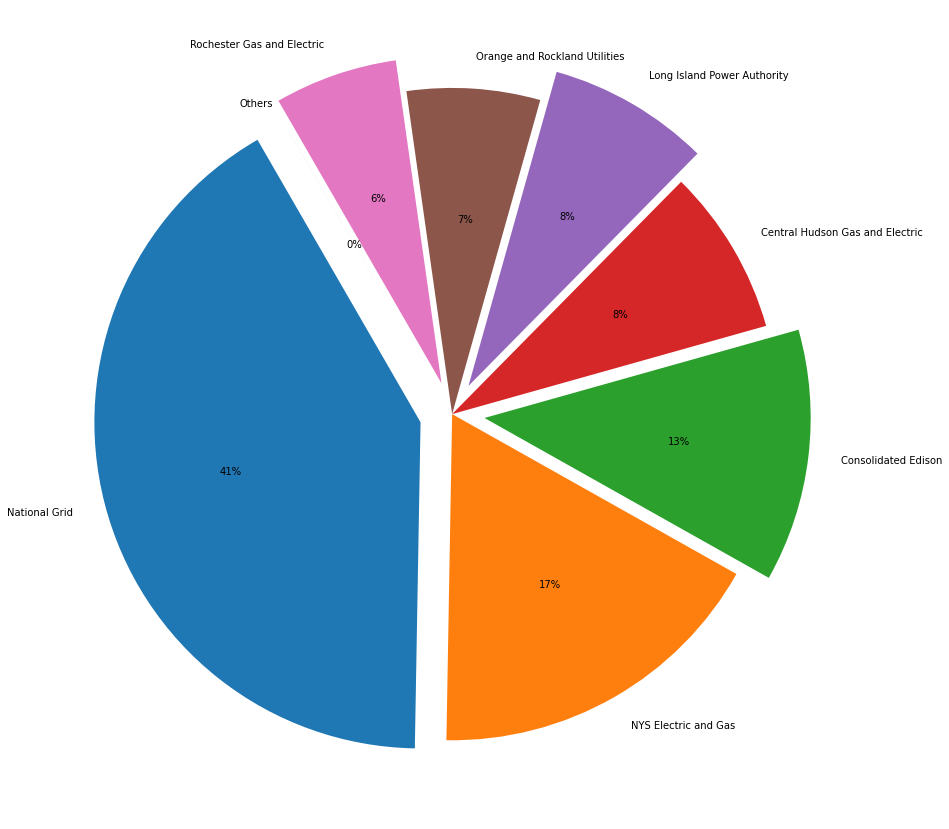

In [22]:
#Electric Utility proportion in Total Name Plate Kwh DC
sql_statement = """SELECT ElectricUtility AS eu,
    SUM(TotNamePlateKWDC) AS DC_Capacity
    FROM Project INNER JOIN PROJECTPROD
    ON PROJECT.PROJECTID=PROJECTPROD.PROJECTID
    GROUP BY eu ORDER  BY DC_Capacity DESC"""

normalized_database_filename = 'normalized1.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_yr = pd.read_sql_query(sql_statement, conn)
fig = plt.figure(figsize=(15,15))
df_yr=df_yr.replace('nan','Others')
separated=(.1,0,0.1,0,0.1,0,0.1,0)
plt.pie(df_yr['DC_Capacity'].tolist(), labels=df_yr["eu"],
        autopct='%1.0f%%', shadow=False, startangle=120,explode=separated)
#plt.legend(df_yr['DC_Generated'].tolist(), labels=df_yr["eu"], loc="lower left")
#plt.axis('equal')
plt.rcParams['font.size'] = 20
plt.show()

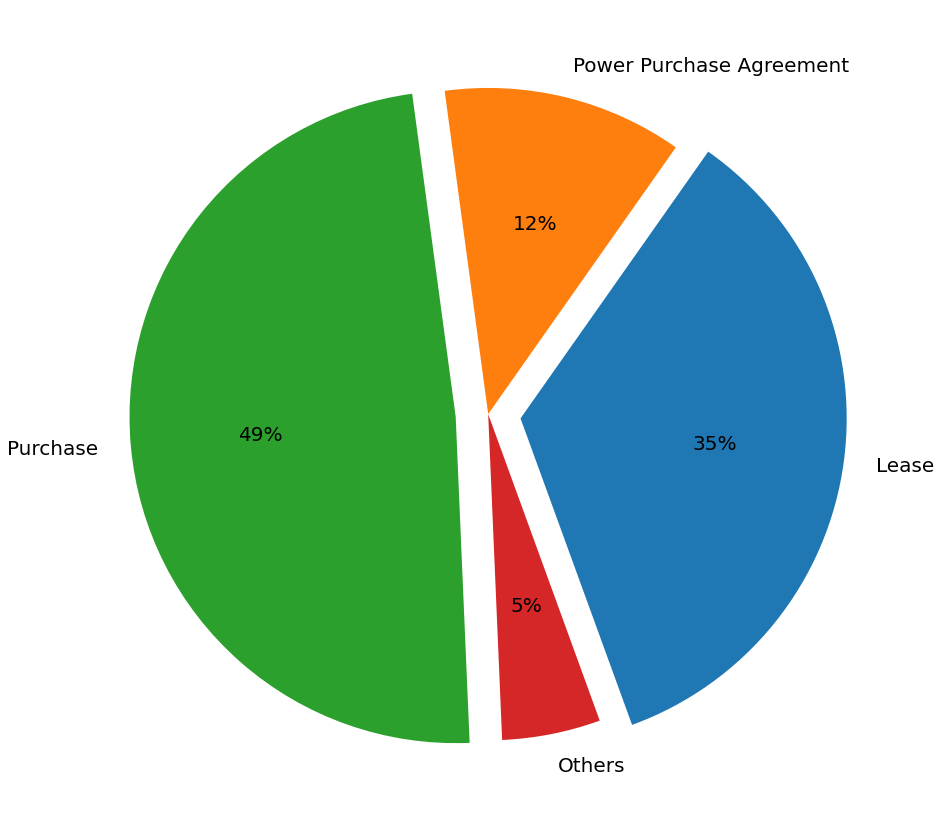

In [23]:
#Distribution of Purchase Type 
sql_statement = """SELECT PurchaseType AS pt,
    COUNT(ProjectID) AS IDS
    FROM Project 
    GROUP BY pt"""

normalized_database_filename = 'normalized1.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_yr = pd.read_sql_query(sql_statement, conn)
fig = plt.figure(figsize=(15,15))
df_yr=df_yr.replace('nan','Others')
separated=(.1,0,0.1,0)
plt.pie(df_yr['IDS'].tolist(), labels=df_yr["pt"],
        autopct='%1.0f%%', shadow=False, startangle=290,explode=separated)
#plt.legend(df_yr['DC_Generated'].tolist(), labels=df_yr["eu"], loc="lower left")
#plt.axis('equal')
plt.rcParams['font.size'] = 20
plt.show()

Text(0.5, 1.0, 'Total Name Plate DC Change over the years')

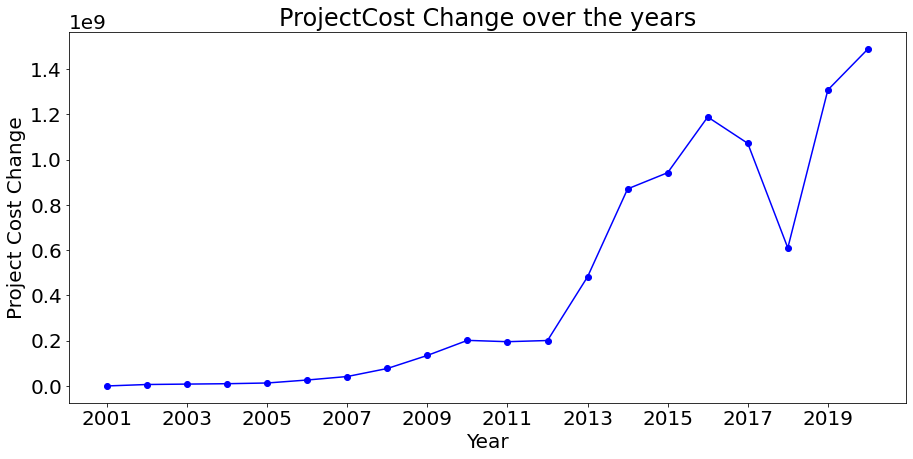

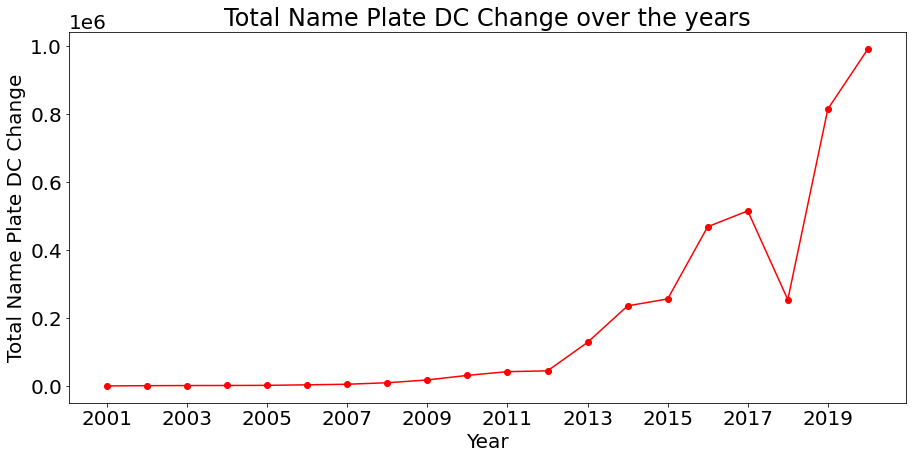

In [24]:
#Changes in the Project Cost and Total KwhDC generated
year=2020
x=[]
y=[]
year1=[]
for yr in range(2001,year+1):
    sql_statement = """SELECT SUM(ProjectCost) AS pc,
    SUM(TotNamePlateKWDC) AS DC_Capacity
    FROM ProjectCost INNER JOIN PROJECTPROD
    ON 
    PROJECTCOST.PROJECTID=PROJECTPROD.PROJECTID
    INNER JOIN ProjectTimeline AS pt
    ON
    pt.PROJECTID=PROJECTPROD.PROJECTID
    where cast(substr(pt.DtAppReceived,length(pt.DtAppReceived)-3,4) as INTEGER)<={0}"""
    
    sql_statement1="""SELECT SUM(ProjectCost) AS pc,
    SUM(TotNamePlateKWDC) AS DC_Capacity
    FROM ProjectCost INNER JOIN PROJECTPROD
    ON 
    PROJECTCOST.PROJECTID=PROJECTPROD.PROJECTID
    INNER JOIN ProjectTimeline AS pt
    ON
    pt.PROJECTID=PROJECTPROD.PROJECTID
    where cast(substr(pt.DtAppReceived,length(pt.DtAppReceived)-3,4) as INTEGER)<={0}"""
    sql_statement = sql_statement.format(yr)
    sql_statement1 = sql_statement1.format(yr-1)
    normalized_database_filename = 'normalized1.db'
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df_yr = pd.read_sql_query(sql_statement, conn)
    df_yr1 = pd.read_sql_query(sql_statement1, conn)
    x.append(df_yr['pc']-df_yr1['pc'])
    y.append(df_yr['DC_Capacity']-df_yr1['DC_Capacity'])
    year1.append(yr)

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 1, 2)
plt.plot(year1, x, '-ok',color='Blue')
plt.xlabel('Year')
plt.xticks(np.arange(min(year1), max(year1)+1, 2.0))
plt.ylabel('Project Cost Change')
plt.title('ProjectCost Change over the years')

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(year1,y, '-ok', color='Red')
plt.xticks(np.arange(min(year1), max(year1)+1, 2.0))
plt.xlabel('Year')
plt.ylabel('Total Name Plate DC Change')
plt.title('Total Name Plate DC Change over the years')

In [25]:
#Highest Solar Producing powerplant in each county
sql_statement = """SELECT MAX(TotNamePlateKWDC),ProjectProd.ProjectID,RemNetMet,GreenCertified,AffSolar FROM
                    ProjectProd INNER JOIN ProjectLocation on 
                    ProjectProd.projectid=ProjectLocation.projectid 
                    INNER JOIN ProjectCost
                    ON ProjectProd.projectid=ProjectCost.projectid
                    group by County order by TotNamePlateKWDC desc """

normalized_database_filename = 'normalized1.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_yr = pd.read_sql_query(sql_statement, conn)
df=pd.read_csv('solar.csv')
ll2=[]
c=[]
remnetmt=[]
#print(df_yr[df_yr['GreenCertified']=='Yes'].index)---->44th project is Green certified
#print(df_yr[df_yr['AffSolar']=='Yes'].index)----->No project is Affordable Solar
for ele in df_yr['RemNetMet']:
    remnetmt.append(ele)
for ele in df_yr['ProjectID']:
    if ele.isnumeric():
        loc=df[df['Project Number']==float(ele)]['Location 1'].tolist()
    else:
        loc=df[df['Project Number']==str(ele)]['Location 1'].tolist()
    if len(loc)==0:
        loc=df[df['Project Number']==str(ele)]['Location 1'].tolist()
    ll2.append(loc)
    
import folium
from folium import plugins
ll1=[]
ll3=[]
for ele in ll2:
    ll=ele[0].split('\n')
    ll3.append(ll[0])
    ll[1]=ll[1].strip('()')
    a=ll[1].split(',')
    a[1]=a[1].strip()
    ll1.append(a)

map = folium.Map(location=ll1[25], zoom_start=6.5)
i=0
k=0
for k in range(0,len(ll1)):
    ele=remnetmt[k]
    if k==44:
        folium.Marker(location = [ll1[k][0], ll1[k][1]],
        popup = ll3[k],
        icon = folium.Icon(color = 'green')).add_to(map)
    else:
        if ele=='Yes':
            folium.Marker(location = [ll1[k][0], ll1[k][1]],
            popup = ll3[k],
            icon = folium.Icon(color = 'gray')).add_to(map)
        else:
            folium.Marker(location = [ll1[k][0], ll1[k][1]],
            popup = ll3[k],
            icon = folium.Icon(color = 'orange')).add_to(map)
    k+=1
map

/Users/marksigalov/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


       TotNamePlateKWDC dtapp ProjectStatus
0                   1.2  2000      Complete
1                   1.2  2000      Complete
2                   3.0  2001      Complete
3                  2.88  2001      Complete
4                   2.4  2001      Complete
...                 ...   ...           ...
112592             8.91  2020      Complete
112593            17.38  2020      Complete
112594             4.83  2020      Complete
112598             8.14  2020      Complete
112600             15.3  2020      Complete

[107081 rows x 3 columns]
 - - - 
TOTAL KW SOLAR UP TO 2020: 
3.824272
 - - - 
Mean Absolute Error: 0.10129945588230832
Mean Squared Error: 0.01026157976205173
Root Mean Squared Error: 0.10129945588230832
[3.09095295 3.4814883  3.87202366 4.26255901 4.65309437 5.04362973]
[4.12463206 4.51516741 4.90570277 5.29623812 5.68677348 6.07730884]


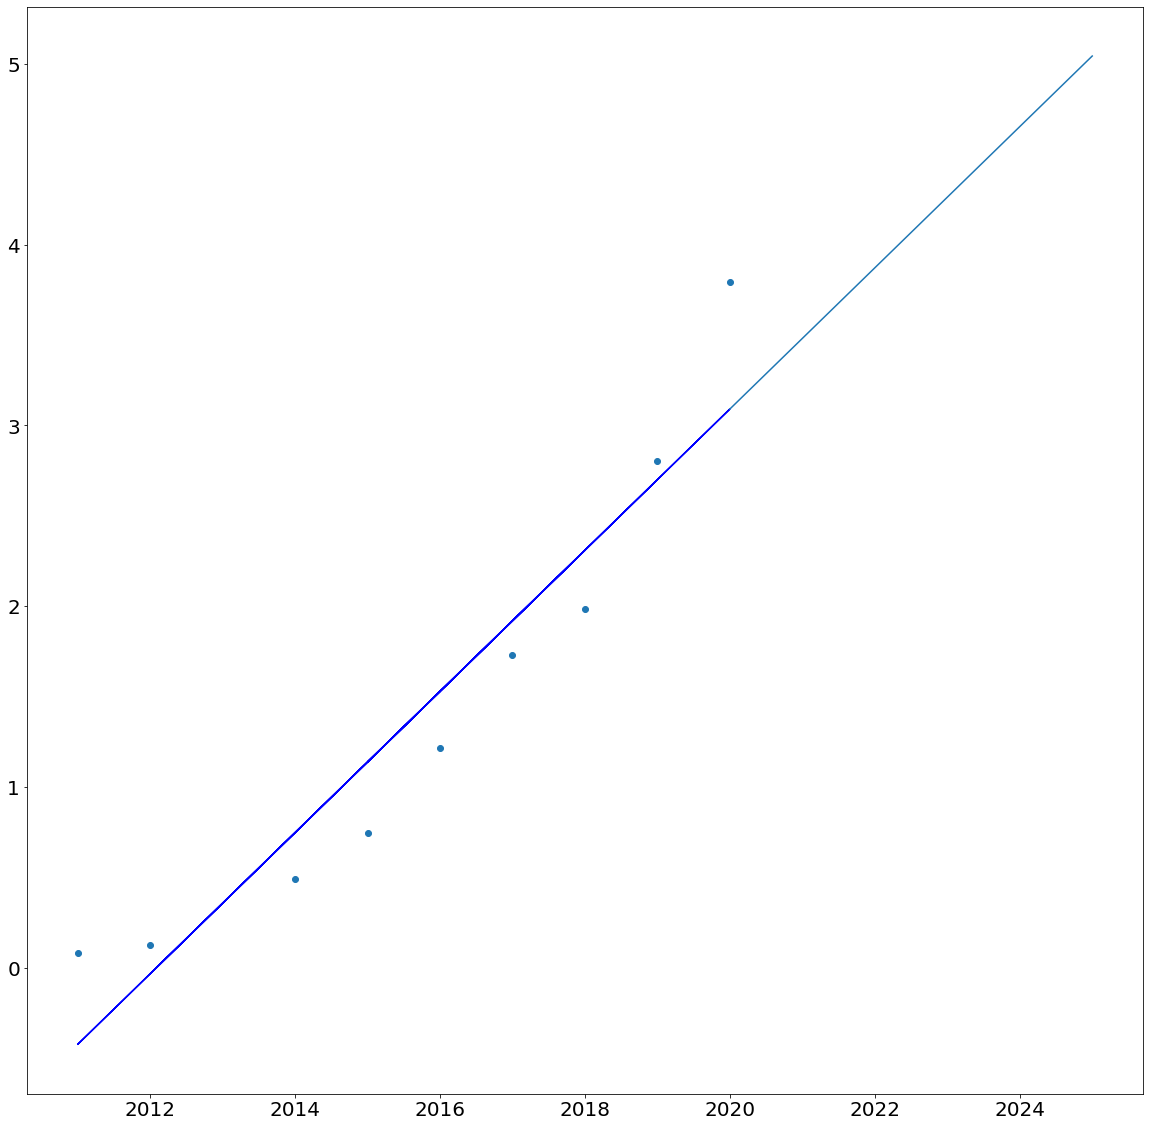

In [415]:
# Uses data from above cell
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib

def KW_date_status():
    sql_statement="""select pp.totNamePlateKWDC, SUBSTR(pt.DtAppReceived, -4) AS dtapp, p.ProjectStatus from 
            ProjectTimeline AS pt 
            INNER JOIN 
            ProjectProd AS pp
            on pt.ProjectID=pp.ProjectID
            INNER JOIN
            Project AS p
            on pt.ProjectID=p.ProjectID order by dtapp ASC"""
    
    normalized_database_filename = 'normalized1.db'
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df = pd.read_sql_query(sql_statement, conn)
    df = df.dropna()
    df = df.replace('','0')
    return df

df = KW_date_status()

kwdc = df['TotNamePlateKWDC']
dar = df['dtapp']
df = df[df['ProjectStatus'] == 'Complete'] 
dfpipe = df[df['ProjectStatus'] == 'Pipeline'] 
print(df)

month = []
kw = []

for ele in kwdc:
    e = round(float(ele))
    kw.append(int(e))

sumkW = 0
for ele in kw:
    sumkW += ele
totkWsolar = sumkW/1000000
print(' - - - ')
print('TOTAL KW SOLAR UP TO 2020: ')
print(totkWsolar) 
print(' - - - ')

years = []
kws = []
for i in range(0,len(dar)):
    if not int(dar[i]) in years:
        years.append(int(dar[i]))
        kws.append(kw[i])
    else:
        kws[len(kws)-1] += kw[i]
        

X = []
missX = []
for i in range(0,10):
    missX.append(years[i])
for i in range(11,21):
    X.append(years[i])
y = []
missy = []
tot1 = 0

for i in range(0,10):
    tot1 += kws[i]
    missy.append(tot1)
tot2 = tot1
for i in range(11,21):
    tot2 += kws[i]
    y.append(tot2)
newy = []
for ele in y:
    newy.append(ele/1000000)

y = newy

d = {'Year':X,'TotalKW':y}
df = pd.DataFrame(d)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


dfp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfp


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.scatter(X_train, y_train)
plt.plot(X_train, regressor.predict(X_train), color = "blue")


future = pd.DataFrame([2020,2021,2022,2023,2024,2025])
print(regressor.predict(future))
diff = totkWsolar - 2.79059289
r = regressor.predict(future) + diff
print(r)
plt.plot(future, regressor.predict(future))

# Prediction for 2025: 6.07730884
# On track!